In [1]:
# %load_ext Cython

In [2]:
# import sys
# sys.version

- histgramで表示するなら光線の本数いらないかも

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np

In [24]:
# %%cython
#透過距離計算用プログラム
#x軸に沿ったスリットの平行移動を考える
def light_receiving_t_d(gradient , intercept, x_k, y_k, distance1, distance2, slit1, slit2, r_d):
    
    #スリットの位置の定義
    #配列制作用
    const = r_d
    i = 0
    x1y1 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x1y1 = np.zeros((const*2 +1,2))
    x2y2 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x2y2 = np.zeros((const*2 +1,2))
    #とりあえず外径の　1.5倍外
    
    #ここおかしくね？？？？
    for d in [tmp*0.1 for tmp in range(-const, const+1)]:
        x1 = d
        y1 = -distance1
        x2 = d
        y2 = -distance2
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        i += 1 


    count_light = [0] * (const *2 + 1)
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    
    count_x = []
    count_y = []
    
    #透過距離
    distance_t = [i for i in range(const * 2 + 1)]
#     distance_t = np.arange(const * 2 + 1)
    #ここのとり方を変える
    #zip使うと遅くなる？→普通のforループに書き直しても良いかも
    for g, i, xk, yk in zip(gradient, intercept, x_k, y_k):
        if yk == 0:
            continue
        for j in range(-const, const +1): #-x,xで動かす
            #スリットと,光線の交点
            a = 0
            b = x1y1[j][1]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1/2
            #1つ目のスリットを超えられるかどうか
            ##この条件がおかしそう
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                #ここの計算間違っている説あり（要確認)
                b = x2y2[j][1]
                x = (i - b)/(a - g)
                s_d = slit2/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += 1
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    
                    
    return count_light, distance_t, count_x, count_y
                    

In [25]:
#高速化を考える

In [26]:
#透過角 を求めるための回転装置をもしたシミュレーション
#90度だけで良さそう
#全ての直線データをぶちこむ
#外周座標は最後の透過角を求めるために必要。
# import time
# %%cython
#回転中心が違うぽい
def light_receiving_t_a(gradient ,intercept, x_k, y_k, distance1, distance2, slit1, slit2, center_x, center_y):
    #print("値が入ってるか？",gradient[0],intercept[0],x_k[0],y_k[0],distance1,distance2)
#     t1 = time.time() 
    
    #まずslitの位置を定義 下準備
    #円管とスリットの距離の定義が必要
#     distance1 = 1
#     distance2 = 1
    i = 0
    x1y1 = np.zeros((900,2))
    x2y2 = np.zeros((900,2))
    s_sita = np.zeros(1801)
    for sita in [tmp*0.1 for tmp in range(900, 1800)]:
        x1 = distance1*np.cos(np.deg2rad(sita)) + center_x
        y1 = distance1*np.sin(np.deg2rad(sita)) + center_y
        x2 = distance2*np.cos(np.deg2rad(sita)) + center_x
        y2 = distance2*np.sin(np.deg2rad(sita)) + center_y
        similar_sita = abs(np.arctan(np.tan(abs(x1)/abs(y1))))
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        s_sita[i] = similar_sita
        i += 1
        
    # 経過時間を表示
#     t2 = time.time()
#     elapsed_time_1 = t2-t1
#     print(f"経過時間：{elapsed_time_1}","秒")
#     print("---------------下準備終了！------------------")
    
#     t3 = time.time() 
    #スリット幅を入力
    #need to change
#     slit1 = 1
#     slit2 = 1
    #ある角度における光線の本数カウント用
    count_light = [0] * 900
    count_x = [0] * 900
    count_y = [0] * 900
#     t_angle = [0] * 900
    t_angle = [0] * 900
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    count_x = []
    count_y = []
    
    for g, i, xk, yk in zip(gradient, intercept, x_k, y_k):
        if yk == 0:
            continue
        for j in range(900): #90度分の回転を表す
            #スリットの傾きと,光線の交点
            a = -np.tan(s_sita[j])
            b = x1y1[j][1] - a*x1y1[j][0]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1*np.cos(abs(s_sita[j]))/2
            #1つ目のスリットを超えられるかどうか
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                b = x2y2[j][1] - a*x2y2[j][0]
                x = (i - b)/(a - g)
                s_d = slit2*np.cos(abs(s_sita[j]))/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += 1
#                     #透過角算出用のx,yもおいておきたい→平均orとりあえずmin,maxの2つをキープしておいて考える。
#                     #怪しい、場合によってはmaxminが大幅に離れてる？→ここはどのへんに値が偏っているのかを見てもいいかも一旦保留
                    
#                     ##ここで透過角を計算する
#                     count_x[j] += xk
#                     count_y[j] += yk
                    #ここで透過角を入れていけば良いんじゃないだろうか？
#                     x_slit2 = x2y2[j][0]
#                     y_slit2 = x2y2[j][1]
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    a = y - yk
                    b = xk - x
                    c = 1
                    d = 0
                    t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
    
    # 経過時間を表示
#     t4 = time.time()
#     elapsed_time_2 = t4-t3
#     print(f"経過時間：{elapsed_time_2}","秒")
#     print("---------------光線の処理完了！------------------")
#     print("スリット1枚目を超えられた本数",cnt_slit1)
#     print("スリット2枚目を超えられた本数",cnt_slit2)
    #print("光線の本数は？",sum(count_light))
    
#     t5 = time.time()
    #jごとの透過角を求める必要がある(横軸)
#     for j in range(900):
#         #ある角度jのときのスリットを透過する外周の点の平均
#         if count_light[j] == 0:
#             continue
#         x_g = count_x[j]/count_light[j]
#         y_g = count_y[j]/count_light[j]
#         x_slit2 = x2y2[j][0]
#         y_slit2 = x2y2[j][1]
#         a = y_slit2 - y_g
#         b = x_g - x_slit2
#         c = 1
#         d = 0
#         t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
        
    # 経過時間を表示
#     t6 = time.time()
#     elapsed_time_3 = t6-t5
#     print(f"経過時間：{elapsed_time_3}","秒")
#     print("---------------透過角算出！------------------")
    
#     print("総実行時間:",(elapsed_time_1+elapsed_time_2+elapsed_time_3)/60,"分")
    
    
    return count_light, t_angle, count_x, count_y

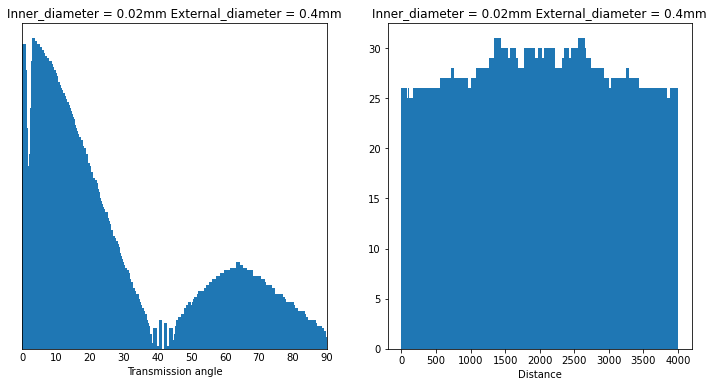

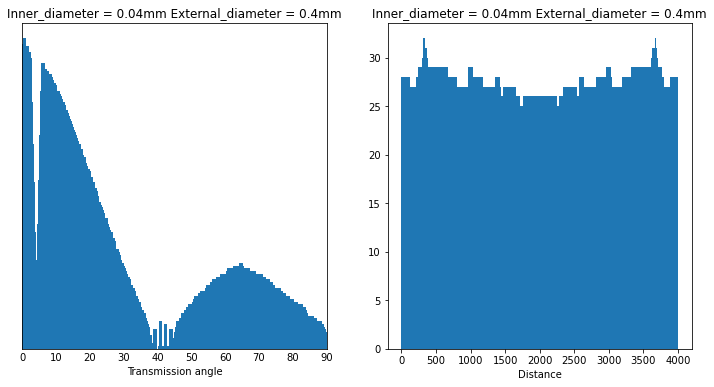

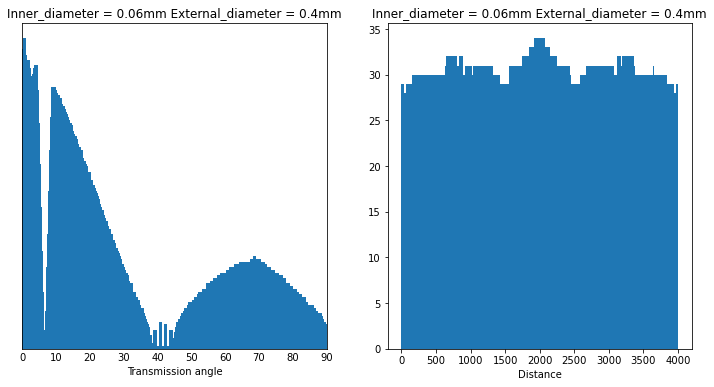

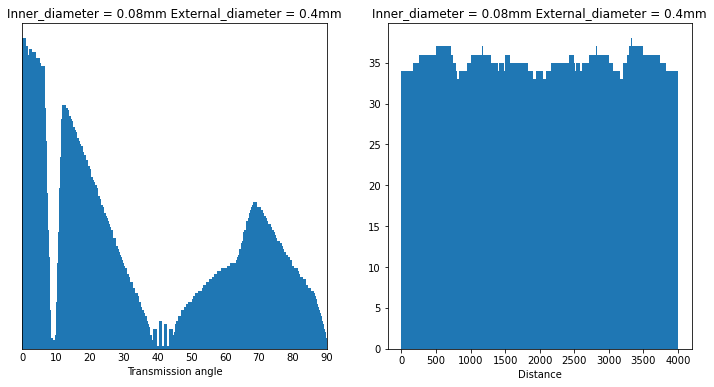

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np

#need to change
max_step = 3000
for step in range(2000, max_step, 1000):
    for threshold in [tmp*0.05 for tmp in range(1, 20)]:
        r = step
        r_i = step*threshold
        r_i = round(r_i)
        #1mm → 10000  0.2mm → 2000 0.05mm → 500
        #円管とスリットの距離
        d1 = 10000
        d2 = d1*1.1
        #スリット幅
        s1 = 2000
        s2 = 500
        #複数のCSVファイルを順次読み込んでグラフを表示していく
        df = pd.read_csv('./data_csv/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
        new_x_a_list = df['x'] 
        new_y_a_list = df['y']
        gradient_list = df['gradient']
        intercept_list = df['intercept']
        light_num_a, toka_angle = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2)
        
        d1 = 50000
        d2 = d1*1.1
        light_num_d, distance = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r)
        
        fig = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_xlim([0,90])
        ax1.bar(toka_angle, light_num_a, width=1.0)
        ax2.bar(distance, light_num_d, width=1.0)
        ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax1.set_xlabel('Transmission angle')
        ax2.set_xlabel('Distance')
        ax1.set_yticklabels([])
#         ax2.set_yticklabels([])
        ax1.tick_params(length=0)
#         ax2.tick_params(length=0)
        plt.show()

In [ ]:
#透過角の最大値を計算するプログラム

In [ ]:
#テスト用
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

r = 40000
r_i = 15000
r_i = round(r_i)
#1mm → 10000  0.2mm → 2000 0.05mm → 500
#円管とスリットの距離

for h1 in range(1000, 30000, 1000):
    for h2 in range(1000, 30000, 1000):
        d1 = r + h1
        d2 = d1 + h2
        #スリット幅
        s1 = 2000
        s2 = 500
        t1 = time.time() 
        #複数のCSVファイルを順次読み込んでグラフを表示していく
        df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
        new_x_a_list = df['x'] 
        new_y_a_list = df['y']
        gradient_list = df['gradient']
        intercept_list = df['intercept']
        center_x_list = df['change_x']
        center_y_list = df['change_y']

        print("データ読み込み数:",len(new_x_a_list))

        t2 = time.time()
        elapsed_time_1 = t2-t1
        print("経過時間：",elapsed_time_1/60,"分")
        print("---------------下準備終了！------------------")
        t3 = time.time() 
        light_num_a, toka_angle = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0])
        print("透過角算出!")
        t4 = time.time()
        elapsed_time_2 = t4-t3
        print("経過時間：",elapsed_time_2/60,"分")
        print("---------------------------------")
        d1 = r + h1
        d2 = d1 + h2
        t5 = time.time() 
        light_num_d, distance, light_x = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r)
        t6 = time.time()
        elapsed_time_3 = t6-t5
        print("経過時間：",elapsed_time_3/60,"分")
        print("---------------------------------")
        fig = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_xlim([0,90])
        ax1.bar(toka_angle, light_num_a, width=1.0)
        ax2.bar(distance, light_num_d, width=1.0)
        ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax1.set_xlabel('Transmission angle')
        ax2.set_xlabel('Distance')
        ax1.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax1.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        
        fig2 = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax3 = fig2.add_subplot(1, 2, 1)
        ax4 = fig2.add_subplot(1, 2, 2)
        sns.distplot(toka_angle, ax = ax3)
        sns.distplot(light_x, ax = ax4)
        ax3.set_xlim([0,90])
        ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax3.set_xlabel('Transmission angle')
        ax4.set_xlabel('Distance')
        ax3.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax3.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        
        
        

データ読み込み数: 74078
経過時間： 0.001041245460510254 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.209172471364339 分
---------------------------------
経過時間： 29.54135792652766 分
---------------------------------
データ読み込み数: 74078
経過時間： 0.0007811665534973144 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.170784997940063 分
---------------------------------
経過時間： 29.804702007770537 分
---------------------------------
データ読み込み数: 74078
経過時間： 0.0010414918263753254 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.218313332398733 分
---------------------------------
経過時間： 29.90754415988922 分
---------------------------------
データ読み込み数: 74078
経過時間： 0.0007810513178507487 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.325246409575144 分
---------------------------------
経過時間： 29.853891094525654 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0010418971379597983 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.189328587055206 分
---------------------------------
経過時間： 29.37872938712438 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007810672124226888 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.096682119369507 分
---------------------------------
経過時間： 29.393738373120627 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007813334465026856 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.208686165014902 分
---------------------------------
経過時間： 29.099988981088003 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007809797922770182 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.155220186710357 分
---------------------------------
経過時間： 29.55112603108088 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0010419567426045737 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.257517286141714 分
---------------------------------
経過時間： 28.902247524261476 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0010410745938618977 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.211340459187825 分
---------------------------------
経過時間： 29.019214701652526 分
---------------------------------


C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007805903752644857 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.1987797498703 分
---------------------------------
経過時間： 29.10478704770406 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007814606030782064 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.1289114356040955 分
---------------------------------
経過時間： 29.172347589333853 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007810393969217936 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.187312912940979 分
---------------------------------
経過時間： 29.20923901796341 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.00104141632715861 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.1835945049921675 分
---------------------------------
経過時間： 28.50173265536626 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007810751597086588 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.259688317775726 分
---------------------------------
経過時間： 29.305788270632426 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007810632387797038 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.228045618534088 分
---------------------------------
経過時間： 29.595226919651033 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007815440495808919 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.164021293322246 分
---------------------------------
経過時間： 29.523136564095815 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.000781087080637614 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.190909886360169 分
---------------------------------
経過時間： 30.833429753780365 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008428136507670085 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.300419147809347 分
---------------------------------
経過時間： 30.646495970090232 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007136821746826172 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.325324149926503 分
---------------------------------
経過時間： 31.11915232737859 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0006885091463724772 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.279603715737661 分
---------------------------------
経過時間： 31.010408449172974 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008483052253723145 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.346112608909607 分
---------------------------------
経過時間： 30.90055196682612 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.000781087080637614 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.256890547275543 分
---------------------------------
経過時間： 30.6048416018486 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008128960927327474 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.339488923549652 分
---------------------------------
経過時間： 30.71998033920924 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008471528689066569 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.29805368979772 分
---------------------------------
経過時間： 31.076649884382885 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0009484450022379557 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.276609639326732 分
---------------------------------
経過時間： 30.313128340244294 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008854508399963379 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.241798690954844 分
---------------------------------
経過時間： 30.268097591400146 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008360147476196289 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.348043322563171 分
---------------------------------
経過時間： 31.197193149725596 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007811546325683594 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.410122481981913 分
---------------------------------
経過時間： 31.21989386876424 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0014753262201944986 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.346259780724844 分
---------------------------------
経過時間： 31.64585035244624 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))


データ読み込み数: 74078
経過時間： 0.000846389929453532 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.294849908351898 分
---------------------------------
経過時間： 29.688117162386575 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))


データ読み込み数: 74078
経過時間： 0.0008412917455037435 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.514375694592794 分
---------------------------------
経過時間： 41.15079749822617 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))


データ読み込み数: 74078
経過時間： 0.0008481542269388834 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.29857534567515 分
---------------------------------
経過時間： 28.88040908972422 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.004507613182067871 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.2065068006515505 分
---------------------------------
経過時間： 28.489937353134156 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.018427189191182455 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.529538345336914 分
---------------------------------
経過時間： 38.33705053329468 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0010220925013224283 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.299395370483398 分
---------------------------------
経過時間： 29.51085005203883 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.001189704736073812 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.291743783156077 分
---------------------------------
経過時間： 28.321956209341685 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0011832555135091146 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.19055978457133 分
---------------------------------
経過時間： 29.026533301671346 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0013433535893758138 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.279546058177948 分
---------------------------------
経過時間： 29.107064859072366 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008385896682739258 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.336489677429199 分
---------------------------------
経過時間： 28.671305561065672 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.08570079406102499 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.182594350973765 分
---------------------------------
経過時間： 27.791378490130107 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0019317229588826498 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.276835501194 分
---------------------------------
経過時間： 29.418150750796 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0008421738942464193 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.622533659140269 分
---------------------------------
経過時間： 40.159185294310255 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0007810791333516439 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.582580995559693 分
---------------------------------
経過時間： 35.332802426815036 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0010406931241353353 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.221842408180237 分
---------------------------------
経過時間： 28.211270089944204 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0016705830891927083 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.249460363388062 分
---------------------------------
経過時間： 28.68567572037379 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.001931329568227132 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.251149046421051 分
---------------------------------
経過時間： 30.192563207944236 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0006875475247701009 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.2260361591974895 分
---------------------------------
経過時間： 28.653728210926054 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.119501527150472 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.333091207345327 分
---------------------------------
経過時間： 27.687521501382193 分
---------------------------------


<ipython-input-4-6464427fb4d8>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))
<ipython-input-4-6464427fb4d8>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure(figsize=(12,6))
C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


データ読み込み数: 74078
経過時間： 0.0013009031613667806 分
---------------下準備終了！------------------
透過角算出!
経過時間： 5.135401566823323 分
---------------------------------


KeyboardInterrupt: 

データ読み込み数: 18748
経過時間： 0.00033244689305623375 分
---------------下準備終了！------------------
透過角算出!
経過時間： 1.4144079089164734 分
---------------------------------
経過時間： 2.718283732732137 分
---------------------------------


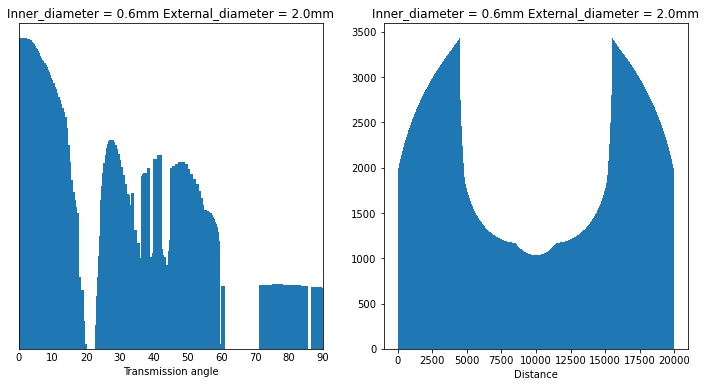

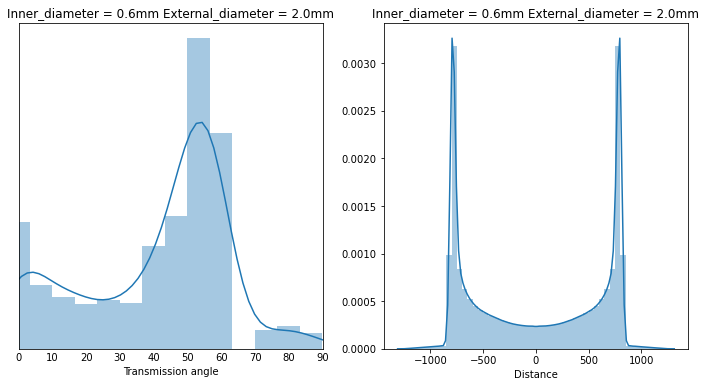

In [27]:
#テスト用
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

r = 10000
r_i = 3000
r_i = round(r_i)
#1mm → 10000  0.2mm → 2000 0.05mm → 500
#円管とスリットの距離

h1 = 1000
h2 = 1000
d1 = r + h1
d2 = d1 + h2
#スリット幅
s1 = 2000
s2 = 500
t1 = time.time() 
#複数のCSVファイルを順次読み込んでグラフを表示していく
df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
new_x_a_list = df['x'] 
new_y_a_list = df['y']
gradient_list = df['gradient']
intercept_list = df['intercept']
center_x_list = df['change_x']
center_y_list = df['change_y']

print("データ読み込み数:",len(new_x_a_list))

t2 = time.time()
elapsed_time_1 = t2-t1
print("経過時間：",elapsed_time_1/60,"分")
print("---------------下準備終了！------------------")
t3 = time.time() 
light_num_a, toka_angle,light_x1,light_y1 = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0])
print("透過角算出!")
t4 = time.time()
elapsed_time_2 = t4-t3
print("経過時間：",elapsed_time_2/60,"分")
print("---------------------------------")
d1 = r + h1
d2 = d1 + h2
t5 = time.time() 
light_num_d, distance,light_x,light_y = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r)
t6 = time.time()
elapsed_time_3 = t6-t5
print("経過時間：",elapsed_time_3/60,"分")
print("---------------------------------")
fig = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim([0,90])
ax1.bar(toka_angle, light_num_a, width=1.0)
ax2.bar(distance, light_num_d, width=1.0)
ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax1.set_xlabel('Transmission angle')
ax2.set_xlabel('Distance')
ax1.set_yticklabels([])
#         ax2.set_yticklabels([])
ax1.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))

fig2 = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)
sns.distplot(toka_angle, ax = ax3)
sns.distplot(light_x, ax = ax4)
ax3.set_xlim([0,90])
ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax3.set_xlabel('Transmission angle')
ax4.set_xlabel('Distance')
ax3.set_yticklabels([])
#         ax2.set_yticklabels([])
ax3.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))




- スリットとの位置を近づけて透過率的な概念を加えてもいいかも？

rの変位域-10000<=r<=10000
取得したxの数 40423306


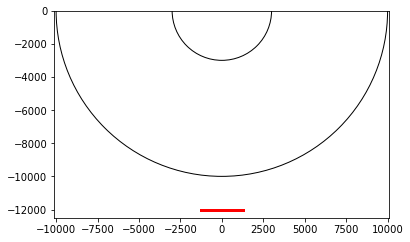

In [28]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x, light_y, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-100,r+100])
g.set_ylim([-12500,0])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x))



rの変位域-10000<=r<=10000
取得したxの数 174283


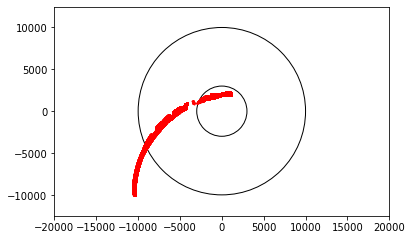

In [30]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x1, light_y1, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-12500,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

C:\Users\mpl\anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\mpl\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\mpl\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


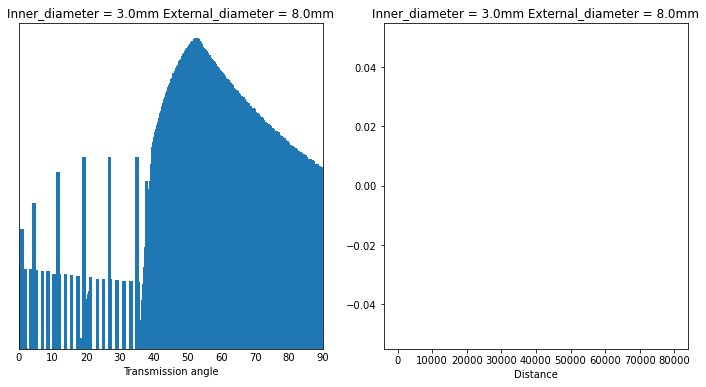

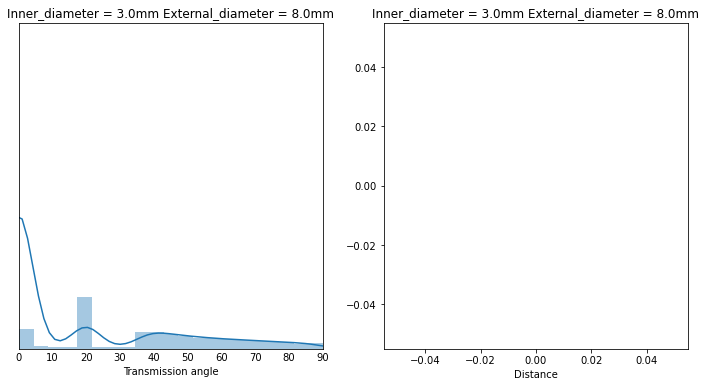

In [82]:
        fig = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_xlim([0,90])
        ax1.bar(toka_angle, light_num_a, width=1.0)
        ax2.bar(distance, light_num_d, width=1.0)
        ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax1.set_xlabel('Transmission angle')
        ax2.set_xlabel('Distance')
        ax1.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax1.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        
        fig2 = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax3 = fig2.add_subplot(1, 2, 1)
        ax4 = fig2.add_subplot(1, 2, 2)
        sns.distplot(toka_angle, ax = ax3)
        sns.distplot(light_x, ax = ax4)
        ax3.set_xlim([0,90])
        ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax3.set_xlabel('Transmission angle')
        ax4.set_xlabel('Distance')
        ax3.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax3.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        
        

In [63]:
max(light_num_d)

146

In [67]:
tmp = 0
tmp2 = 0
for i in range(len(light_num_a)):   
    if tmp < light_num_a[i]:
        tmp = light_num_a[i]
        tmp2 = toka_angle[i]

print("光線数",tmp,"透過角",tmp2)

tmp3 = 0
tmp4 = 0

for i in range(int(len(light_num_d)/2)):   
    if tmp3 < light_num_d[i]:
        tmp3 = light_num_d[i]
        tmp4 = distance[i]

max_value = max(light_num_d)
max_index = light_num_d.index(max_value)
tmp3 = distance[max_index]
print(tmp)

print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")

光線数 629 透過角 3.28915723970423
629
光線数 629 透過距離 6.0 mm


もう少し大きな値で回す必要がある。

# 内径計算
$n$:屈折率 $d$:内径 $D$:外径 $a$:透過距離

$$
d = \frac{-a^3\pm\sqrt{a^6+a^2D^2(n^2(D^2-a^2)-a^2})}{n^2(D^2-a^2)-a^2}
$$

In [68]:
#透過距離からの計算
a_toka = (distance[-1]-tmp3*2)/10000
D = r/10000
n = 1.49/1.000292

d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))

print("内径1:",d_ans_1,"内径2:",d_ans_2)



内径1: 3.5537027697709194 内径2: 0.9506275437128308


In [69]:
#透過角からの計算
sita_ans = np.deg2rad(tmp2)
d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))

print(d_ans_3)

0.17541804158086893


In [70]:
#期待する内径
print(r_i*2/10000,"mm")

2.0 mm
